In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display

import tensorflow as tf
print(tf. __version__)

from SQ_decoder import SQ_decoder, to_tf

from train_NN import Train_NN, Train_NN_V

2.10.0


In [2]:
# define class VAE
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, sq_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        regularizer = None
        self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(sq_dim)),
            tf.keras.layers.Reshape((sq_dim,1)),
            tf.keras.layers.Conv1D(
                filters=32, kernel_size=3, strides=2, activation='relu',
                kernel_regularizer = regularizer,
                name='conv1d_en'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(
                latent_dim + latent_dim, 
                kernel_regularizer = regularizer,
                name='dense_en'),
        ]
        )
        
        self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(
                40*32, activation=tf.nn.relu, 
                kernel_regularizer = regularizer,
                name='dense_de'),
            tf.keras.layers.Reshape(target_shape=(40, 32)),
            tf.keras.layers.Conv1DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same', activation='relu',
                kernel_regularizer = regularizer,
                name='conv1dtrs_de'),
            tf.keras.layers.Conv1DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.Reshape((sq_dim,))
        ]
        )
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = 0*tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [3]:
# load pre-trained decoder
latent_dim = 3
q_rs_dim = 80
model = VAE(latent_dim, q_rs_dim)

export_path = './saved_model/SQ_cVAE_MSE_ns/'
model_name = 'model_conv_stride2_exp6'
export_name = export_path + model_name

reload_sm = model.load_weights(export_name, by_name=False, skip_mismatch=False, options=None)
model_r = reload_sm._root
model_decoder = model_r.decoder

# freeze loaded layers
for i, layers in enumerate(model_decoder.layers):
        model_decoder.layers[i].trainable = False

model_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_de (Dense)            (None, 1280)              5120      
                                                                 
 reshape_1 (Reshape)         (None, 40, 32)            0         
                                                                 
 conv1dtrs_de (Conv1DTranspo  (None, 80, 32)           3104      
 se)                                                             
                                                                 
 conv1d_transpose (Conv1DTra  (None, 80, 1)            97        
 nspose)                                                         
                                                                 
 reshape_2 (Reshape)         (None, 80)                0         
                                                                 
Total params: 8,321
Trainable params: 0
Non-trainable 

In [4]:
# Augmented layers
# Add a dense layer to pre-trained decoder
regularizer = tf.keras.regularizers.L2(5e-2)
dense_3 = [
    tf.keras.layers.InputLayer(input_shape=(3)),
    tf.keras.layers.Dense(6, 
                kernel_regularizer = None,
                name='dense_in'),
    tf.keras.layers.Dense(6, 
                kernel_regularizer = None,
                name='dense_in2'),]

# # rescaling the dense layer to the value range of decoder input
# rescale = [tf.keras.layers.Rescaling(scale=1.0, offset=0.0)]
# rescale[0].trainable = False

model_aug = tf.keras.Sequential(dense_3)#+rescale)

In [5]:
class Decoder_aug(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Decoder_aug,self).__init__()
        self.latent_dim = latent_dim
        self.aug_layers = model_aug
        self.decoder_layers = model_decoder
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(64, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.aug_layers(x), num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder_layers(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    def sample_normal(self, x):
        mean, logvar = self.encode(x)
        eps = tf.random.normal(shape=(64, self.latent_dim))
#         z_samples = [e*tf.exp(logvar*.5) + mean for e in eps]
#         logits_samples = [self.decode(z, apply_sigmoid=True) for z in z_samples]
#         z_samples = eps*tf.exp(logvar*.5) + mean
#         logits_samples = self.decode(z_samples, apply_sigmoid=True)
        def zsample(e):
            return e*tf.exp(logvar*.5) + mean
        z_samples = tf.map_fn(zsample,eps)
        def logitsample(z):
            return self.decode(z, apply_sigmoid=True)
        logits_samples = tf.map_fn(logitsample,z_samples)
        
        logits_std = tf.math.reduce_std(logits_samples,axis=0)
        logits_mean = tf.math.reduce_mean(logits_samples,axis=0)
        
        return logits_mean, logits_std

## Load data

In [6]:
parameters_zscore = 1

In [7]:
# Training set
sq_min = np.exp(-5) # minimum of sq

if 1:
    X_file = './training_set/input_grid_all_GPR80.csv'
    Y_file = './training_set/target_grid_all.csv'
else:
    X_file = './training_set/input_random_all_GPR80.csv'
    Y_file = './training_set/target_random_all.csv'
    
fX = open(X_file, 'r', encoding='utf-8-sig')
sq = np.genfromtxt(fX, delimiter=',').astype(np.float32)
sq[sq<=0] = sq_min

fY = open(Y_file, 'r', encoding='utf-8-sig')
target = np.genfromtxt(fY, delimiter=',').astype(np.float32)

eta = target[:,0]
kappa = target[:,1]
Z = target[:,3]
A = target[:,2]
lnZ = np.log(Z)
lnA = np.log(A)

eta_mean = np.mean(eta)
eta_std = np.std(eta)
kappa_mean = np.mean(kappa)
kappa_std = np.std(kappa)
A_mean = np.mean(A)
A_std = np.std(A)

# normalization
eta_z = (eta-eta_mean)/eta_std
kappa_z = (kappa-kappa_mean)/kappa_std
A_z = (A-A_mean)/A_std

if parameters_zscore:
    parameters_train = np.array([eta_z,kappa_z,A_z]).T
else:
    parameters_train = np.array([eta,kappa,A]).T

sq_dim = sq.shape[1]
sample_train_dim = sq.shape[0]
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

# rescale
r_eta = 1
sq_rs = np.zeros((sample_train_dim,q_rs_dim),dtype='float32')
for i in range(sample_train_dim):
    qr_eta = q*r_eta
    interpolating_function = interp.interp1d(qr_eta[3:],sq[i,3:],fill_value='extrapolate')
    sq_rs[i,:] = interpolating_function(q_rs).astype(np.float32)
sq_rs[sq_rs<=0] = sq_min

print('eta ~ N({:0.4f},{:0.4f})'.format(np.mean(eta),np.var(eta)))
print('kappa ~ N({:0.4f},{:0.4f})'.format(np.mean(kappa),np.var(kappa)))
print('A ~ N({:0.4f},{:0.4f})'.format(np.mean(A),np.var(A)))

eta ~ N(0.2325,0.0169)
kappa ~ N(0.2600,0.0208)
A ~ N(13.0000,52.0000)


In [8]:
# Test set
if 0:
    X_file = './training_set/input_grid_all_GPR80.csv'
    Y_file = './training_set/target_grid_all.csv'
else:
    X_file = './training_set/input_random_all_GPR80.csv'
    Y_file = './training_set/target_random_all.csv'
    
fX_test = open(X_file, 'r', encoding='utf-8-sig')
sq_test = np.genfromtxt(fX_test, delimiter=',').astype(np.float32)
sq_test[sq_test<=0] = sq_min

fY_test = open(Y_file, 'r', encoding='utf-8-sig')
target_test = np.genfromtxt(fY_test, delimiter=',').astype(np.float32)

eta_test = target_test[:, 0]
kappa_test = target_test[:, 1]
Z_test = target_test[:, 3]
A_test = target_test[:, 2]
lnZ_test = np.log(Z_test)
lnA_test = np.log(A_test)

# normalization
eta_test_z = (eta_test-eta_mean)/eta_std
kappa_test_z = (kappa_test-kappa_mean)/kappa_std
A_test_z = (A_test-A_mean)/A_std

if parameters_zscore:
    parameters_test = np.array([eta_test_z,kappa_test_z,A_test_z]).T
else:
    parameters_test = np.array([eta_test,kappa_test,A_test]).T

sample_test_dim = sq_test.shape[0]

# Rescale
r_eta_test = 1
sq_test_rs = np.zeros((sample_test_dim,q_rs_dim),dtype='float32')
for i in range(sample_test_dim):
    qr_eta = q*r_eta_test
    interpolating_function_test = interp.interp1d(qr_eta[3:],sq_test[i,3:],fill_value='extrapolate')
    sq_test_rs[i,:] = interpolating_function_test(q_rs)
sq_test_rs[sq_test_rs<=0] = sq_min

print('eta ~ N({:0.4f},{:0.4f})'.format(np.mean(eta_test),np.var(eta_test)))
print('kappa ~ N({:0.4f},{:0.4f})'.format(np.mean(kappa_test),np.var(kappa_test)))
print('A ~ N({:0.4f},{:0.4f})'.format(np.mean(A_test),np.var(A_test)))

eta ~ N(0.2301,0.0157)
kappa ~ N(0.2595,0.0193)
A ~ N(12.9685,48.1309)


Preprocess/Postprocess

In [9]:
# Mask
mask_length = 0
sq_mask = sq_rs
sq_test_mask = sq_test_rs

for i in range(sample_train_dim):
    sq_mask[i,0:mask_length] = sq_rs[i,mask_length]
for i in range(sample_test_dim):
    sq_test_mask[i,0:mask_length] = sq_test_mask[i,mask_length]

# rescale the training set SQ to range [0,1]
exp_scale = 6
def f_inp(sq):
    return tf.math.log(sq)/exp_scale/2 + 0.5

# transform the decoder output to SQ
def f_out_sample(x):
    return f_out_tf(tf.sigmoid(x))

# rescale the fitting parameters to range [0,1]
def fp_inp(parameters):
    return np.log(parameters)/exp_scale/2

def fp_out(parameters_pred):
    return np.exp((parameters_pred*2)*exp_scale)

def f_out(sq_pred):
    return np.exp((sq_pred*2-1)*exp_scale) # inverse of f_inp

# def f_inp2(sq):
#     return np.log(sq/4.5)/1.5/2 + 0.5

# def f_out2(sq_pred):
#     return tf.math.exp((sq_pred*2-1)*1.5)*4.5


## Shuffle data

In [10]:
# Merge sets
train_size = sq.shape[0]
test_size = sq_test.shape[0]
print('training set size = {} \ntest set size = {}'.format(train_size,test_size))
    
batch_size = 64
batch_size_test = 1000

train_SQ_dataset = (tf.data.Dataset.from_tensor_slices(f_inp(sq_mask))
                 .shuffle(train_size, seed=6174).batch(batch_size))
test_SQ_dataset = (tf.data.Dataset.from_tensor_slices(f_inp(sq_test_mask))
                .shuffle(test_size, seed=6174).batch(batch_size_test))

train_parameters_dataset = (tf.data.Dataset.from_tensor_slices((parameters_train))
                 .shuffle(train_size, seed=6174).batch(batch_size))
test_parameters_dataset = (tf.data.Dataset.from_tensor_slices((parameters_test))
                .shuffle(test_size, seed=6174).batch(batch_size_test))

training set size = 18750 
test set size = 15000


In [11]:
# Pick a sample of the test set for generating output images
# no random
i = 0
for test_SQ_batch in train_SQ_dataset:
    if i == 6:
        test_SQ_sample = test_SQ_batch[0:16, :]
    i+=1
i = 0
for test_parameters_batch in train_parameters_dataset:
    if i == 6:
        test_parameters_sample = test_parameters_batch[0:16, :]
    i+=1

## Training

In [12]:
def compute_loss_l2(parameters, SQ, model):
    # SQ rescaled to range [0,1]
    
    mean, logvar = model.encode(parameters)
    eps = model.reparameterize(mean, logvar)
    SQ_pred = model.sample(eps)
    
    err_l2 = tf.reduce_mean((SQ_pred-SQ)**2)
    loss = err_l2
    
    return loss

### Fine tuning

In [13]:
def compute_loss(parameters, SQ, model):
    # SQ rescaled to range [0,1]
    
    mean, logvar = model.encode(parameters)
    eps = model.reparameterize(mean, logvar)
    SQ_pred = model.sample(eps)
    
    SQ_mean, SQ_std = model.sample_normal(parameters)
    
    err = SQ_mean-SQ
    err_l2 = tf.reduce_mean((err)**2)
    log_sigma = tf.math.log(SQ_std**2)/2
#     err_gauss = -tf.reduce_mean(tf.math.exp(-(f_inp(f_out_sample(model(parameters)))-SQ)**2)/2/sigma**2)
#     err_var = tf.math.reduce_variance(err)
    err_NLL = tf.reduce_mean((err/tf.math.exp(log_sigma))**2/2 + log_sigma)
    
    loss = err_NLL
    
    return loss

In [14]:
model = Decoder_aug(latent_dim=3)

export_path = './saved_model/SQ_NLL_variation/SQ_NLL_variation_aug/'
model_name = 'SQ_NLL_variation_aug'
export_name = export_path + model_name

aug_layers_loaded = model.aug_layers.load_weights(export_name, by_name=False, skip_mismatch=False, options=None)
model.aug_layers = aug_layers_loaded._root

# unfreeze layers
for i, layers in enumerate(model.decoder_layers.layers):
        model.decoder_layers.layers[i].trainable = True
model.aug_layers.summary()
model.decoder_layers.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_in (Dense)            (None, 6)                 24        
                                                                 
 dense_in2 (Dense)           (None, 6)                 42        
                                                                 
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_de (Dense)            (None, 1280)              5120      
                                                                 
 reshape_1 (Reshape)         (None, 40, 32)            0         
                                                                 
 conv1dtrs_de (Conv1DTranspo  (None,

In [15]:
train_rate = 1e-3
batch_size = 256
batch_size_test = 1000
n_epoch = 750
f_loss=compute_loss

fig_path = './figures/SQ_NLL_variation/'
model_path = './saved_model/SQ_NLL_variation/'

train_SQ_dataset = (tf.data.Dataset.from_tensor_slices(f_inp(sq_mask))
                 .shuffle(train_size, seed=6174).batch(batch_size))
train_parameters_dataset = (tf.data.Dataset.from_tensor_slices((parameters_train))
                 .shuffle(train_size, seed=6174).batch(batch_size))
data_train = [train_SQ_dataset,train_parameters_dataset]
data_test = [test_SQ_dataset,test_parameters_dataset]

train_NN_1 = Train_NN_V(n_epoch,batch_size,batch_size_test,train_rate,f_loss,model,
                        data_train, data_test, test_SQ_sample, test_parameters_sample,
                        fig_path,model_path)
train_NN_1.epoch_prev = 250

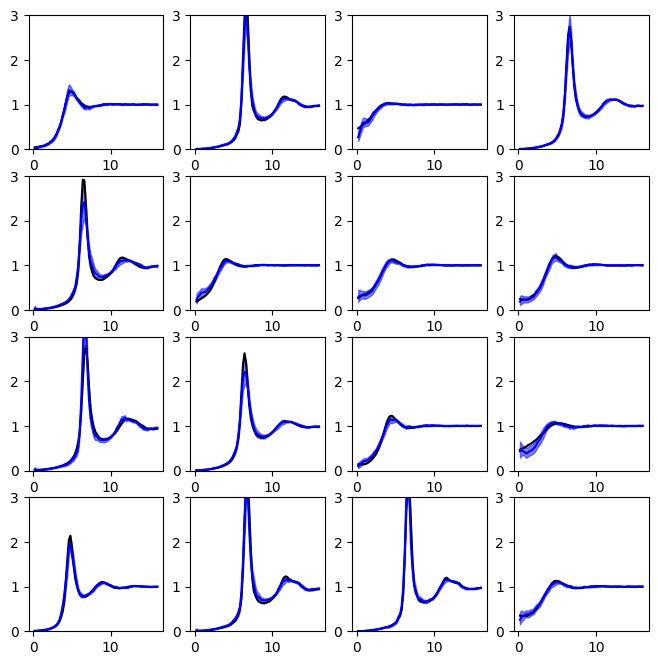

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [35:28<00:00,  2.84s/it]


In [16]:
train_NN_1.fit()

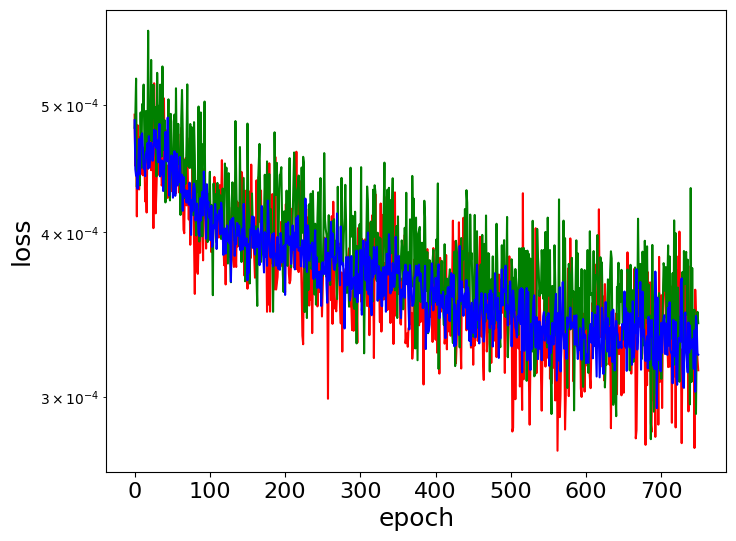

In [17]:
err_test_all = np.hstack((train_NN_1.err_test_epoch))
err_train_all = np.hstack((train_NN_1.err_train_epoch))
err_validate_all = np.hstack((train_NN_1.err_validate_epoch))
err_test_all = np.hstack((train_NN_1.err_test_epoch))
err_train_all = np.hstack((train_NN_1.err_train_epoch))
err_validate_all = np.hstack((train_NN_1.err_validate_epoch))
errname = './figures/SQ_NLL_variation/test_err_ft.png'
fig,ax = plt.subplots(1,1, figsize=[8, 6])
ax.plot(err_test_all,'-r')
ax.plot(err_train_all,'-g')
ax.plot(err_validate_all,'-b')
ax.set_yscale('log')
#plt.ylim(4e-3, 1e-1)
ax.set_xlabel('epoch',fontsize=18)
ax.set_ylabel('loss',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig(errname)
plt.show()

In [18]:
train_NN_1.save_model_aug(model_path_sub = 'SQ_NLL_variation_aug_ft/', 
                          model_name='SQ_NLL_variation_aug_ft')
train_NN_1.save_model_decoder(model_path_sub = 'SQ_NLL_variation_decoder_ft/', 
                              model_name='SQ_NLL_variation_decoder_ft')

In [19]:
# Save training errors
from scipy.io import loadmat, savemat
mdic = {'err_test':train_NN_1.err_test_epoch,
       'err_train':train_NN_1.err_train_epoch,
       'err_validate':train_NN_1.err_validate_epoch}

savemat(model_path+'SQ_NLL_variation_ft_err.mat', mdic)

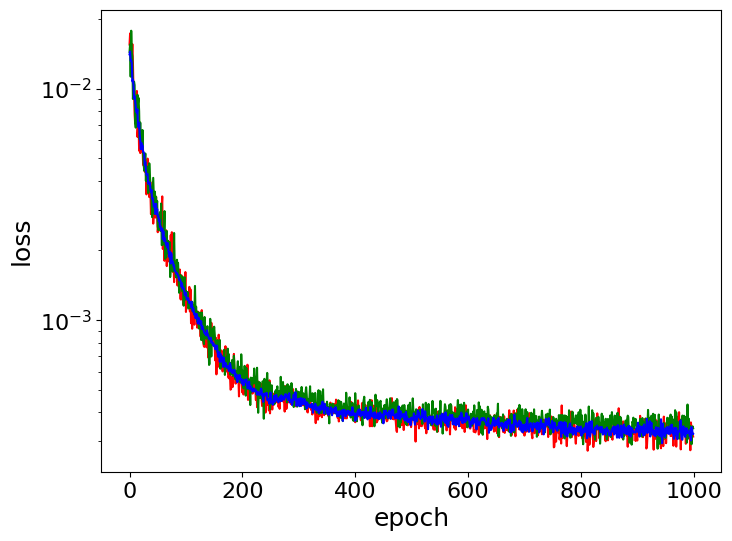

In [23]:
loadeddata = loadmat(model_path+'SQ_NLL_variation_aug_err.mat')
err_test = loadeddata['err_test'][0]
err_train = loadeddata['err_train'][0]
err_validate = loadeddata['err_validate'][0]
err_test_all = np.hstack((err_test,train_NN_1.err_test_epoch))
err_train_all = np.hstack((err_train,train_NN_1.err_train_epoch))
err_validate_all = np.hstack((err_validate,train_NN_1.err_validate_epoch))
# err_test_all = np.hstack((train_NN_1.err_test_epoch))
# err_train_all = np.hstack((train_NN_1.err_train_epoch))
# err_validate_all = np.hstack((train_NN_1.err_validate_epoch))
errname = './figures/SQ_NLL_variation/test_err_all.png'
fig,ax = plt.subplots(1,1, figsize=[8, 6])
ax.plot(err_test_all,'-r')
ax.plot(err_train_all,'-g')
ax.plot(err_validate_all,'-b')
ax.set_yscale('log')
#plt.ylim(4e-3, 1e-1)
ax.set_xlabel('epoch',fontsize=18)
ax.set_ylabel('loss',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig(errname)
plt.show()

In [1]:
anim_file = './SQ_NLL_variation.gif'

import glob
import imageio
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./figures/SQ_NLL_variation/[0-9][0-9][0-9][0-9].png')
    filenames = sorted(filenames)
    i = 0
    for filename in filenames:
        if i%5==0:
            image = imageio.imread(filename)
            writer.append_data(image)
        i+=1
    image = imageio.imread(filename)
    writer.append_data(image)

def compute_loss(parameters, SQ, model):
    # SQ rescaled to range [0,1]
    
    mean, logvar = model.encode(parameters)
    eps = model.reparameterize(mean, logvar)
    SQ_pred = model.sample(eps)
    
    SQ_mean, SQ_std = model.sample_normal(parameters)
    
    err = SQ_mean-SQ
    err_l2 = tf.reduce_mean((err)**2)
    log_sigma = tf.math.log(SQ_std**2)/2
#     err_gauss = -tf.reduce_mean(tf.math.exp(-(f_inp(f_out_sample(model(parameters)))-SQ)**2)/2/sigma**2)
#     err_var = tf.math.reduce_variance(err)
    err_NLL = tf.reduce_mean((err/tf.math.exp(log_sigma))**2/2 + log_sigma)
    
    loss = err_NLL
    
    return loss